# 映像(画像)品質評価に関する調査 第2回 SSIM (Structural SIMilarity: 構造的類似度)

第1回はディジタル画像の表現方法とMSE/PSNRによる品質評価について触れました。
PSNRは画像データの変化を表す統計量として扱いやすいものですが、人間の知覚品質とは一致しないケースがあります。人間の知覚品質に近づける画像品質評価のための指標はいくつか提案されてきましたが、その中でもWangらによって提案されたSSIM(Structural SIMilarity: 構造的類似度) という指標は、十数年たった今でも最も広く利用されている指標の1つです。

## 人間の視覚システムの特性

まずはPSNRのスコアと人間の知覚品質に差が発生する例をあげます。差異が生まれる理由を人間の視覚システム(以下、HVS: Human Visual System)の特性から解説します。

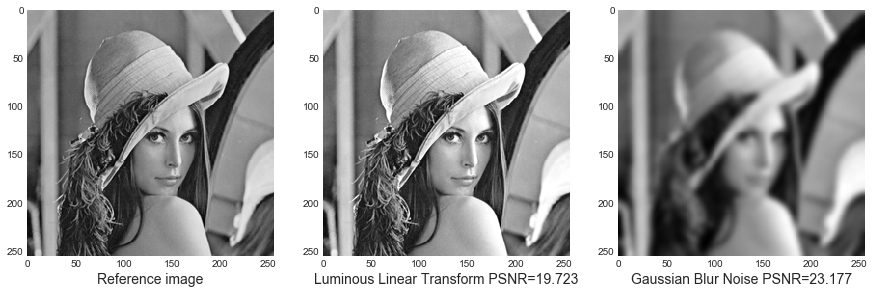

In [1]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3)

def mse(ref, dis):
    d = ref.astype(np.float64) - dis.astype(np.float64)
    return np.mean(d **2)

def psnr(ref, dis):
    assert ref.shape == dis.shape, "Input images must have the same dimensions."
    pixel_max = 255
    return 20 * math.log10(pixel_max / math.sqrt(mse(ref, dis)))

grayscale_luminous_array = np.clip(grayscale_array * 1.2, 0, 255) # Luminous Linear Transform
grayscale_luminous_psnr = psnr(grayscale_array, grayscale_luminous_array)

grayscale_blur_img = grayscale_img.filter(ImageFilter.GaussianBlur(3)) # Gaussian Blur
grayscale_blur_psnr = psnr(grayscale_array, grayscale_blur_array)

ax1, ax2, ax3 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2])
ax1.imshow(grayscale_array, cmap='gray')
ax1.set_xlabel("Reference image", fontsize=14)
ax2.imshow(grayscale_luminous_array, cmap='gray')
ax2.set_xlabel(f"Luminous Linear Transform PSNR={grayscale_luminous_psnr:.03f}", fontsize=14)
ax3.imshow(grayscale_blur_array, cmap='gray')
ax3.set_xlabel(f"Gaussian Blur Noise PSNR={grayscale_blur_psnr:.03f}", fontsize=14)
plt.show()

人間の目からみると輝度をあげた真ん中の画像はそれほど品質が劣化していないようにみえるかもしれません。
しかしPSNRのスコア上は、ガウシアンブラーを加えてぼかした右の画像のスコアを下ってしまいました。

HVSには *Luminous Masking* と呼ばれる特性があり、これはウェーバーの法則(刺激を与えたとき、その違いを知覚できる弁別閾は、刺激の強さに比例する)に従います。相対的な輝度の変化に関して人間の眼は敏感ですが、絶対的な輝度の変化にはあまり敏感ではありません。

また人間の眼は画像の中に存在する物体の「構造」に着目します。構造というのは画像の中にでてくる物体や模様の輪かくなどの情報と考えてもらえれば大丈夫です。Wangらは、この構造に関する情報が失われる変換を、人間は大きな品質劣化が生じた認知すると考えました。ガウシアンブラーにより輪郭がぼやけていることで画像の中に描かれている物体の構造が分かりづらくなってくると人間の視覚システムは品質が劣化したように感じます。

SSIMは *Structural SIMilarity (構造的類似度)* という名前の通り、「構造」に着目した品質評価指標です。

## SSIMのシステムダイアグラム

画像の中に存在する物体表面の明るさは照明の反射の影響を受けます。つまり物体の構造的な情報を調べるためには、照明の影響を分離する必要があります。

そこでWangらは照明の影響が「画像全体の輝度の平均値」と「コントラスト」で表現できると考え、それらを取り除いた値が「構造」であると定義しました。

SSIM のシステムダイアグラムを次に示します。

![SSIM System Diagram](./image/ssim-system-diagram.png)

出展: [Image Quality Assessment: From Error Visibility to
Structural Similarity](https://ieeexplore.ieee.org/document/1284395/), 6ページより

この図は2つの画像(信号 $\boldsymbol{x}$ と信号 $\boldsymbol{y}$)を入力としたときに、それぞれの信号情報を「明るさ」「コントラスト」「構造」の3つの成分に分解し比較していることを示しています。どちらかの入力信号が完璧な品質を持つ画像であると仮定することで、品質劣化が定量的に測定できます。

### 明るさ (Luminous Measurement)

まずは画像全体の明るさを計算します。
グレースケール画像は各ピクセルにその明るさが保持されているため、その平均値は画像全体の明るさを示しています。入力信号を $\boldsymbol{x}$ とすると、次式により求まります。

$l(\boldsymbol{x}) = \frac{1}{N} \sum_{i=1}^{N} x_i$

In [2]:
def measure_luminance(img):
    return np.mean(img)

In [3]:
measure_luminance(grayscale_array)

123.54656982421875

In [4]:
measure_luminance(grayscale_luminous_array)

148.15081787109375

### コントラスト (Contrast Measurement)

コントラストは明るさにどれだけばらつきがあるかということなので、入力信号の標本標準偏差で表されます。

$c(\boldsymbol{x}) = (\frac{1}{N-1} \sum_{i=1}^{N} (x_i - \mu_x)^2)^{\frac{1}{2}}$

In [5]:
def measure_contrast(img):
    return np.std(img, ddof=1)

In [6]:
measure_contrast(grayscale_array)

47.63670723861667

In [7]:
measure_contrast(grayscale_luminous_array)

56.95765034347143

### 構造 (Structure Measurement)

先程述べたようにWangらは、照明の影響が「画像全体の輝度の平均値」と「コントラスト」で表現できると考え、それらを取り除いた値が「構造」であると定義しました。これらを取り除くには次式のように入力信号を明るさとコントラストで正規化します。

$s(\boldsymbol{x}) = \frac{\boldsymbol{x} - \mu_x}{\sigma_x}$

In [8]:
def measure_structure(img):
    return (img - measure_luminance(img)) / measure_contrast(img)

In [9]:
measure_structure(grayscale_array)

array([[ 0.80722267,  0.78623046,  0.74424603, ...,  0.97516039,
         0.97516039,  0.36638616],
       [ 0.80722267,  0.80722267,  0.74424603, ...,  1.01714482,
         1.05912925,  0.49233945],
       [ 0.82821489,  0.76523824,  0.74424603, ...,  0.78623046,
         0.57630831, -0.17941143],
       ...,
       [-1.54390541, -1.52291319, -1.50192098, ..., -0.87215453,
        -0.66223238, -0.66223238],
       [-1.64886648, -1.56489762, -1.54390541, ..., -0.64124016,
        -0.47330244, -0.53627909],
       [-1.6698587 , -1.50192098, -1.54390541, ..., -0.49429466,
        -0.43131801, -0.36834137]])

## 評価関数の設計

次はこの3つの値をどのように組み合わせて最終的なSSIMの値とするかを考えていきます。
組み合わせ方はいろいろあるかと思いますが大事なのは、次の3つの特性を備えていると指標は扱いやすいでしょう。

1. Symmetry: $S(\boldsymbol{x}, \boldsymbol{y}) = S(\boldsymbol{y}, \boldsymbol{x})$
2. Boundedness: $S(\boldsymbol{x}, \boldsymbol{y}) \le 1$
3. Unique maximum: $S(\boldsymbol{x}, \boldsymbol{y}) =1$ if and only if $\boldsymbol{x} = \boldsymbol{y}$

これは別の表現をすると

1. 2つの入力画像を入れ替えても同じ値をとること
2. 出力値が有界があること。SSIMの最大値は 1 です。
3. 2つの入力信号が同じ場合にのみ、最大値をとること

を表しています。それではSSIMが設計した比較関数について見ていきましょう。

### 明るさの比較 (Luminance Comparison)

入力信号\boldsymbol{x} の \boldsymbol{y}明るさを比較する関数は、ダイナミックレンジ(各ピクセルが取りうる値の範囲) $L$ と小さな定数 $K1 (K1 << 1)$ を導入して次式より求まります。

$l(\boldsymbol{x}, \boldsymbol{y}) = \frac{2 \mu_x \mu_y + C_1}{\mu_x^2 + \mu_y^2 + C_1}$, 但し $C_1 = (K_1 L)^2$

それではこの式が先程あげた3つの特性をみたすかどうか確認しましょう。
まずこの式は明らかに $\boldsymbol{x}$ と $\boldsymbol{y}$ を入れ替えても同じ値をとります。
また $\mu_y$ が $\mu_x$ に限りなく近づく際に、分母・分子ともに $2\mu_x^2$ に近づくことからBoundednessの性質とUnique Maximumの性質を満たすことが確認できます。

In [10]:
K1 = 0.01
L = 2**8 - 1  # 8 bits grayscale image
C1 = (K1 * L)**2

def compare_luminance(x, y):
    assert x.shape == y.shape, "x and y should be the same shape"
    mux = measure_luminance(x)
    muy = measure_luminance(y)
    return (2 * mux * muy + C1) / (mux**2 + muy**2 + C1)

In [11]:
compare_luminance(grayscale_array, grayscale_luminous_array)

0.983734912637548

### コントラストの比較

コントラストの比較も組み立てる式は同じです。こちらも定数 $K2 (K2 << 1)$ を導入し次式より求まります。

$c(\boldsymbol{x}, \boldsymbol{y}) = \frac{2 \sigma_x \sigma_y + C_2}{\sigma_x^2 + \sigma_y^2 + C_2}$

In [12]:
K2 = 0.03
L = 2**8  # 8 bits grayscale image
C2 = (K1 * L)**2

def compare_contrast(x, y):
    assert x.shape == y.shape, "x and y should be the same shape"
    mux = measure_contrast(x)
    muy = measure_contrast(y)
    return (2 * mux * muy + C2) / (mux**2 + muy**2 + C2)

In [13]:
compare_contrast(grayscale_array, grayscale_luminous_array)

0.9842608258170946

### 構造の比較

構造の比較では少しアプローチを変えます。
構造は平均値と標本標準偏差により正規化されたベクトル値でした。
このベクトル値の相関を示すために相関係数を導入します。相関係数は標本共分散 $\sigma_{xy}$ を用いて次式で表現できます。

$s(\boldsymbol{x}, \boldsymbol{y}) = \frac{\sigma_{xy} + C_3}{\sigma_x \sigma_y + C_3}$ 但し、 $\sigma_{xy} = \frac{1}{N-1} \sum_{i=1}^N (x_i - \mu_x) (y_i - \mu_y)$

相関係数は幾何学的に三角関数のコサインと同じ性質を持ち、2つのベクトルが最も近づくときに1、最も離れるときに-1をとります。

In [14]:
C3 = C2/2

def compare_structure(x, y):
    assert x.shape == y.shape, "Input images must have the same dimensions."
    x, y = x.astype(np.float64), y.astype(np.float64)
    sxy = np.mean(x * y) - (np.mean(x) * np.mean(y))
    sxsy = np.std(x, ddof=1) * np.std(y, ddof=1)
    return (sxy + C3) / (sxsy + C3)

In [15]:
compare_structure(grayscale_array, grayscale_luminous_array)

0.9998223055468185

In [16]:
compare_structure(grayscale_array, grayscale_blur_array)

0.9320673921880964

標本共分散は式変形により「 $\boldsymbol{x}$ と $\boldsymbol{y}$ の積の平均値 - $\boldsymbol{x}$ と $\boldsymbol{y}$ それぞれの平均値の積」より計算しています。

### SSIMの計算

最後はSSIMの計算です。SSIMは $\alpha$ 、 $\beta$ 、 $\gamma$ を導入し、各項目の重要度を調整します。

$SSIM(\boldsymbol{x}, \boldsymbol{y}) = [l(\boldsymbol{x}, \boldsymbol{y}) ]^\gamma ・ [c(\boldsymbol{x}, \boldsymbol{y})]^\beta ・ [s(\boldsymbol{x}, \boldsymbol{y})]^\gamma$

Wnagらの提案論文では、 式を簡単にするために $\alpha = \beta = \gamma = 1$ そして $C_3 = \frac{C_2}{2}$ とし、次のように簡略化します。

$SSIM(\boldsymbol{x}, \boldsymbol{y}) = \frac{(2 \mu_x \mu_y + C_1) (2 \sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1) (\sigma_x^2 + \sigma_y^2 + C_2)}$

### 画像に対するSSIMの計算

SSIMの計算を画像に適用する際には、画像の一部をウィンドウとして切り出し、そこに対してSSIMの計算を行います。これは画像の統計情報が空間に応じて大きく変化するからです。これはつまり画像の歪みも空間に応じて変化することを示しています。

また錐体の多く集まっている網膜の中心部分である中心窩（ちゅうしんか：fovea centralis）の特性により、人間の眼は視界の中心部分は詳細に見えるものの周りはぼやけて見えます。この特性を再現するために切り出したウィンドウに対して、円状に対称性をもつガウシアン重み付け関数を適用します。

In [17]:
sp.signal.gaussian(11, std=1.5)

array([0.00386592, 0.0285655 , 0.13533528, 0.41111229, 0.8007374 ,
       1.        , 0.8007374 , 0.41111229, 0.13533528, 0.0285655 ,
       0.00386592])

Wangらの提案論文では11x11のウィンドウを切り出し、そこに標準偏差1.5のガウシアン重み付け関数を適用します。ガウシアン重み付け関数を適用するとこのように中心に近づくほど重みが大きく両端に近づくほど重みが小さくなります。

In [18]:
def crop(ar, crop_width, copy=False, order='K'):
    ar = np.array(ar, copy=False)
    crops = np.lib.arraypad._validate_lengths(ar, crop_width)
    slices = [slice(a, ar.shape[i] - b) for i, (a, b) in enumerate(crops)]
    if copy:
        cropped = np.array(ar[slices], order=order, copy=True)
    else:
        cropped = ar[slices]
    return cropped

In [19]:
def compare_ssim(X, Y, K1=0.01, K2=0.03, window_size=11, sigma=1.5):
    assert X.shape == Y.shape, "Input images must have the same dimentions."
    assert K1 > 0, "K1 must be positive"
    assert K2 > 0, "K2 must be positive"
    assert sigma > 0, "sigma must be positive"
    assert window_size % 2 == 1, "Window size must be odd."
    
    ndim = X.ndim

    NP = window_size ** ndim  # 11 ** 2
    cov_norm = NP / (NP - 1)  # sample covariance
    
    X = X.astype(np.float64)
    Y = Y.astype(np.float64)

    # compute (weighted) means
    ux = sp.ndimage.gaussian_filter(X, sigma=sigma)
    uy = sp.ndimage.gaussian_filter(Y, sigma=sigma)

    # compute (weighted) variances and covariances
    uxx = sp.ndimage.gaussian_filter(X * X, sigma=sigma)
    uyy = sp.ndimage.gaussian_filter(Y * Y, sigma=sigma)
    uxy = sp.ndimage.gaussian_filter(X * Y, sigma=sigma)
    vx = cov_norm * (uxx - ux * ux)
    vy = cov_norm * (uyy - uy * uy)
    vxy = cov_norm * (uxy - ux * uy)

    R = 255
    C1 = (K1 * R) ** 2
    C2 = (K2 * R) ** 2

    A1, A2, B1, B2 = ((2 * ux * uy + C1,
                       2 * vxy + C2,
                       ux ** 2 + uy ** 2 + C1,
                       vx + vy + C2))
    D = B1 * B2
    S = (A1 * A2) / D

    # to avoid edge effects will ignore filter radius strip around edges
    pad = (window_size - 1) // 2

    # compute (weighted) mean of ssim
    mssim = crop(S, pad).mean()
    return mssim

## SSIM スコアの確認

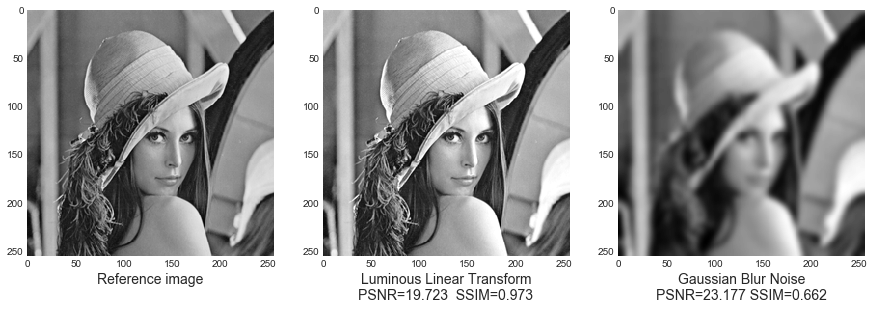

In [20]:
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 3)

# Luminous Linear Transform
grayscale_luminous_ssim = compare_ssim(grayscale_array, grayscale_luminous_array)

# Gaussian Blur
grayscale_blur_ssim = compare_ssim(grayscale_array, grayscale_blur_array)

ax1, ax2, ax3 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2])
ax1.imshow(grayscale_array, cmap='gray')
ax1.set_xlabel("Reference image", fontsize=14)
ax2.imshow(grayscale_luminous_array, cmap='gray')
ax2.set_xlabel(f"Luminous Linear Transform\nPSNR={grayscale_luminous_psnr:.03f}  SSIM={grayscale_luminous_ssim:.03f}", fontsize=14)
ax3.imshow(grayscale_blur_array, cmap='gray')
ax3.set_xlabel(f"Gaussian Blur Noise\nPSNR={grayscale_blur_psnr:.03f} SSIM={grayscale_blur_ssim:.03f}", fontsize=14)
plt.show()

最初に紹介した輝度を上げた画像とガウシアンブラーをかけた画像のSSIMスコアを計算しました。
輝度をあげた画像は 0.973 と最大値1に非常に近く、品質の劣化が少ないことを示しています。
一方でガウシアンブラーをかけた画像は 0.662 とスコアの低下が大きく、この画像のケースではPSNRよりも人間の知覚品質に近づいていることが確認できます。

一方で、SSIMは次に上げる点においていまだ検討の余地があります。

* ウィンドウサイズやK1, K2の値などWangらによって決められたパラメーターが存在し、この値の妥当性については検討の余地があるかもしれません。他の研究者が別の値を提案している論文も存在します。
* 解明されているHVSの特性は他にも複数あります。Google/Butterargli では、網膜の中心窩にも青色受容体がほとんど存在せず、HVSの青色の知覚は赤色/緑色に比べて空間解像度が低いことを考慮しています。
* 動画の品質評価という面では、動きの特性を考慮した情報は特にありません。Netflix/VMAF ではMotionという動きに関する情報が特徴量として導入されています。

## まとめと関連研究

今回は [「Image Quality Assessment: From Error Visibility to Structural Similarity (2003)」](https://ieeexplore.ieee.org/document/1284395/)の論文を元に、SSIM Indexの理論を実装を交えて解説しました
Wangらは何度かSSIMに関する提案論文を発表してきましたが、この論文は評価実験のデータセットを増やし理論も一般化したこの論文は多くの文献から参照されています。

一方でこの論文の他にも次のような関連研究が発表されています。

### Multi-scale structural similarity for image quality assessment (2004)
* 著者: Zhou Wang, Eero P. Simoncelli and Alan C. Bovik
* 論文PDF: http://www.cns.nyu.edu/~zwang/files/papers/msssim.pdf
* 概要: ローパスフィルタとダウンサンプリングを繰り返すことで、異なる解像度の画像を用意・比較することで精度をあげる。

### Exact global histogram specification optimized for structural similarity (2008)

* 著者: Alireza Nasiri Avanaki
* arxiv: https://arxiv.org/abs/0901.0065
* 論文PDF: https://slideheaven.com/exact-global-histogram-specification-optimized-for-structural-similarity.html
* 概要: Fast SSIMとかとは違って、高速化ではなく人間の知覚品質にさらに近づけることを目的にしている。
* 実装例: [scikit-image](https://github.com/scikit-image/scikit-image/blob/master/skimage/measure/_structural_similarity.py)

### Understanding and simplifying the structural similarity metric (2008)

* 著者: David M. Rouse, Sheila S. Hemami
* 論文: Understanding and simplifying the structural similarity metric
* メモ: Netflix/VMAFで実装されているMulti Scale SSIM 。必要な乗算処理が20%削減されるものの、Wangらが使っているLIVEデータベースによる主観評価との差異は、WangのMS-SSIMより1%離れている(低下している)
* 実装例: [Netflix/VMAF](https://github.com/Netflix/vmaf/blob/33e8dc675ace44dd1412b318c31eb3378612744c/feature/src/ms_ssim.c#L268-L291)

### Fast structural similarity index algorithm (2011)
* 著者: Ming-Jun Chen • Alan C. Bovik
* 論文PDF: https://live.ece.utexas.edu/publications/2011/chen_rtip_2011.pdf
* 概要:
    * 既存のSSIMおよびMS-SSIMよりも高速かつ計算の簡単なFast SSIMおよびFast MS-SSIMを提案
    * 提案されたFast SSIMは並列計算の最適化をしないSSIMより2.68倍、FAST MS-SSIMはMS-SSIMより10倍高速
    * リアルタイム画像および映像品質評価に利用する